In [14]:
import os

os.chdir("/home/sein/ksc_model/model")

In [634]:
#원본
import os
import utils
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from cluster import make_data
import configparser

def mysql_knob_dataframe(wk, knobs_path):
    knobs_path = os.path.join(knobs_path, str(wk))
    config_len = len(os.listdir(knobs_path))
    cnf_parser = configparser.ConfigParser()
    pd_mysql = pd.DataFrame()
    for idx in range(config_len):
        cnf_parser.read(os.path.join(knobs_path, f'my_{idx}.cnf'))
        conf_dict = cnf_parser._sections['mysqld']
        tmp = pd.DataFrame(data=[conf_dict.values()], columns=conf_dict.keys())
        pd_mysql = pd.concat([pd_mysql, tmp])
        
    pd_mysql = pd_mysql.reset_index(drop=True)
    pd_mysql = pd_mysql.drop(columns=['log-error', 'bind-address'])
    return pd_mysql

def KmeanClustering(data, k):
    np_external = external.to_numpy()
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(np_external)
    labels = kmeans.labels_
    
    fig = plt.figure(figsize=(7,7))
    fig.set_facecolor('white')
    for i, label in enumerate(labels):
        if label == 0:
            color = 'navy'
        elif label == 1:
            color = 'tomato'
        elif label == 2:
            color = 'green'
        elif label == 3:
            color = 'orange'
        plt.scatter(np_external[i,0],np_external[i,1], color=color)

    plt.xlabel('tps')
    plt.ylabel('latency')
    plt.show()
    return labels

def get_data(knob_path, external_path, wk):
    raw_knobs = mysql_knob_dataframe(wk, knob_path)
    external_ = pd.read_csv(os.path.join(external_path, f'external_results_{wk}.csv'), index_col=0)
    latency_columns = []
    for col in external_.columns:
        if col.find("latency") == 0 and col != 'latency_max' and col != 'latency_CLEANUP':
            latency_columns.append(col)
    external = external_[['tps']].copy()
    external['latency'] = external_[latency_columns].max(axis=1)
    return raw_knobs, external

def get_class_num(data):
    cls, cnt = np.unique(data, return_counts=True)
    print(f'# of the largest class / # of data = {max(cnt) / sum(cnt)}')
    for _ in range(len(cls)):
        print(f'{cls[_]} : {cnt[_]}')

In [5]:
!pwd

/home/sein/ksc_model/model


===================8 workload===================


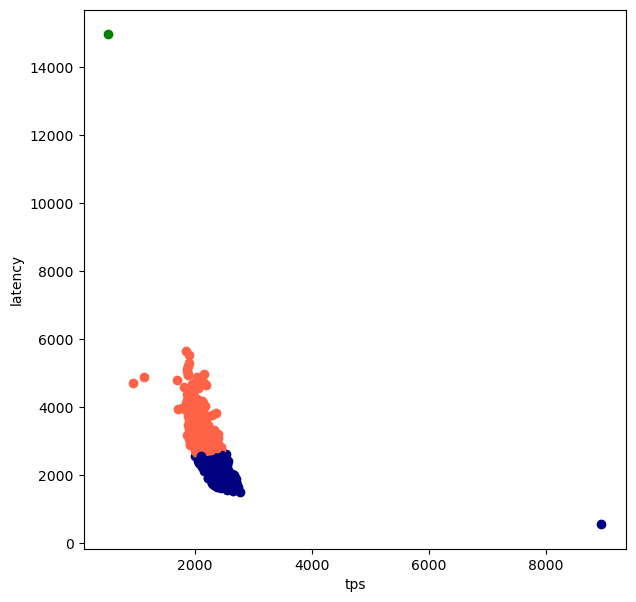

0 : 1792
1 :  207
2 :    1


In [635]:
# import get_data
# import KmeanClustering
KNOB_PATH = ('../data/configs_new_dataset/')
EXTERNAL_PATH=("../data/configs_new_dataset/external_new_dataset/")

wk = 8
print(f'==================={wk} workload===================')
raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)
labels = KmeanClustering(external, 3)
cls, cnt = np.unique(labels, return_counts=True)
print(f'{cls[0]} : {cnt[0]:4}\n{cls[1]} : {cnt[1]:4}\n{cls[2]} : {cnt[2]:4}')
#print(f'score = {davies_bouldin_score(raw_knobs, labels)}')
print(f'==================================================')

XGBoost Classifier

In [636]:
def get_class_num(data):
    cls, cnt = np.unique(data, return_counts=True)
    print(f'# of the largest class / # of data = {max(cnt) / sum(cnt)}')
    for _ in range(len(cls)):
        print(f'{cls[_]} : {cnt[_]}')

In [832]:
#####parameter with GridSearch

import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


wk = 9
print(f'=WK{wk}===============================================================')
raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)
np_external = external.to_numpy()
kmeans = KMeans(n_clusters=3)
kmeans.fit(np_external)
labels = kmeans.labels_
get_class_num(labels)

X_train, X_test, y_train, y_test = train_test_split(raw_knobs, labels, test_size=0.4, shuffle=True)
X_scaler = MinMaxScaler().fit(X_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)

# clf = xgb.XGBClassifier(n_estimators=50, learning_rate = 0.001, max_depth=14, random_state=0)
#clf = xgb.XGBClassifier(n_estimators=50, learning_rate = 0.001 ,max_depth=14)
clf = xgb.XGBClassifier(n_estimators=1500, learning_rate = 0.005, 
                        max_depth = 6, max_leaves = 255, n_jobs=-1)
clf.fit(scaled_X_train, y_train)
pred = clf.predict(scaled_X_test)
print('********true********')
get_class_num(y_test)
print('********pred********')
get_class_num(pred)                                                                        
# print('accuracy: ',clf.score(scaled_X_test, y_test))
# print('f1 score ', f1_score(y_test, pred, average='weighted'))
# print('balanced accuracy: ', balanced_accuracy_score(y_test, pred))
print('f1 score : ',f1_score(y_test, pred, average='weighted'))
print('precision : ',precision_score(y_test, pred, average='weighted'))
print('recall : ',recall_score(y_test, pred, average='weighted'))
print('accuracy: ',clf.score(scaled_X_test, y_test))
print('balanced accuracy: ', balanced_accuracy_score(y_test, pred))


=WK9===============================================================
# of the largest class / # of data = 0.8935
0 : 1787
1 : 210
2 : 3
********true********
# of the largest class / # of data = 0.895
0 : 716
1 : 83
2 : 1
********pred********
# of the largest class / # of data = 0.91625
0 : 733
1 : 67
f1 score :  0.9614709799861972
precision :  0.9613757355785872
recall :  0.96375
accuracy:  0.96375
balanced accuracy:  0.5755199569226628


/home/sein/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [361]:
import torch
import torch.nn as nn
#class for cluster prediction

class ReshapeNet(nn.Module):    # OANet
    # def __init__(self, input_dim, hidden_dim, output_dim, group_dim):
    def __init__(self, input_dim, hidden_dim, output_dim, group_dim):
        
        super(ReshapeNet, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.group_dim = group_dim
      

        # self.embedding = nn.Linear(self.wk_num, self.hidden_dim)
        self.embedding = nn.Linear(1, self.hidden_dim)
        
        self.knob_fc = nn.Sequential(nn.Linear(self.input_dim, self.hidden_dim*self.group_dim), nn.Sigmoid()) # (22, 1) -> (group*hidden, 1)
        self.attention = nn.MultiheadAttention(self.hidden_dim, 1)
        self.active = nn.ReLU()
        self.fc = nn.Linear(self.hidden_dim, self.output_dim)

    def forward(self, x, wk):
        
        self.embed_wk = self.embedding(wk) # (batch, 4) -> (batch, dim)
        self.embed_wk = self.embed_wk.unsqueeze(1) # (batch, 1, dim)
        self.x = self.knob_fc(x) # (batch, 22) -> (batch, group*hidden)
        self.res_x = torch.reshape(self.x, (-1, self.group_dim, self.hidden_dim)) # (batch, group, hidden)
        
        # attn_ouptut = (1, batch, hidden), attn_weights = (batch, 1, group)
        self.attn_output, self.attn_weights = self.attention(self.embed_wk.permute((1,0,2)), self.res_x.permute((1,0,2)), self.res_x.permute((1,0,2)))
        self.attn_output = self.active(self.attn_output.squeeze())
        outs = self.attn_output
        self.outputs = self.fc(outs)
        return self.outputs

In [833]:
class model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(model, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        # self.embedding_X = nn.Embedding(num_embeddings = self.input_dim, embedding_dim = 3)
        # self.embedding_Y = nn.Embedding(num_embeddings = self.output_dim, embedding_dim = 3)
        self.embedding_X = nn.Linear(self.input_dim, self.hidden_dim)
        self.embedding_Y = nn.Linear(3, self.hidden_dim) 
        self.attention = nn.MultiheadAttention(self.hidden_dim, num_heads=1, batch_first = True)  
        # self.linear_Latency = nn.Linear(32, 1)
        # self.linear_TPS = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        # self.softmax = nn.Softmax()
        self.linear = nn.Linear(32, self.output_dim)
        
        
    def forward(self,x,y):        
        embedding_X = self.embedding_X(x)
        #embedding_X = embedding_X.unsqueeze(1)
        embedding_Y = self.embedding_Y(y)
        #embedding_Y = embedding_Y.unsqueeze(1) 

        attn_output, attn_output_weights = self.attention(embedding_Y, embedding_X, embedding_X)
        # attn_output = self.active(attn_output.squeeze())
        attn_output = self.relu(attn_output)
        metrics = self.linear(attn_output)
        # TPS = self.linear_TPS(attn_output)
        # Latency = self.linear_Latency(attn_output)
        return metrics , attn_output_weights

In [82]:
metrics.shape

torch.Size([64, 2])

In [299]:
# Y값을 one-hot으로 바꾸기

# X_train.index
#전체 linear model에 대한 input, ouput // input = configuration , output = tps, latency
#input값은 attention을 통해 나온 attn_output , output은 tps와 latency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
import torch
import torch.nn as nn
random_seed = 777
import random
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#workload6에 대한 external metric
#EXTERNAL = pd.read_csv("../data/configs_new_dataset/external_new_dataset/external_results_6.csv", index_col=0)

raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)
#external metric에 대한 scaling
# scaler_EXT = StandardScaler().fit(EXTERNAL)
# EXT_Preprocessing = scaler_EXT.transform(EXTERNAL)
scaled_knob = MinMaxScaler().fit(raw_knobs)
knob_preprocessing = scaled_knob.transform(raw_knobs)
knob_preprocessing = pd.DataFrame(knob_preprocessing)
#scaled_external = RobustScaler().fit(external)
#scaled_external = Normalizer().fit(external)
scaled_external = StandardScaler().fit(external)
external_preprocessing = scaled_external.transform(external)
external_preprocessing = pd.DataFrame(external_preprocessing)
#X = configuraion, Y = scaling external metrics
X_train, X_test, y_train, y_test = train_test_split(knob_preprocessing, external_preprocessing, test_size=0.4, shuffle=True)


# train_index = X_train.index
# test_index = X_test.index

#X,Y값 scaling
# X_scaler = MinMaxScaler().fit(X_train)
# #Y_scaler = StandardScaler().fit(y_train)
# Y_scaler = RobustScaler().fit(y_train)
 
# scaled_X_train = torch.Tensor(X_scaler.transform(X_train)).cuda().cpu()
# scaled_X_test = torch.Tensor(X_scaler.transform(X_test)).cuda().cpu()
# scaled_Y_train = torch.Tensor(Y_scaler.transform(y_train)).cuda().cpu()
# scaled_Y_test = torch.Tensor(Y_scaler.transform(y_test)).cuda().cpu()

#####수정
# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
# scaled_Y_train = Y_scaler.transform(y_train)
# scaled_Y_test = Y_scaler.transform(y_test)
#####

scaled_X_train = X_train
scaled_X_test = X_test
scaled_Y_train = y_train
scaled_Y_test = y_test
# train_TPS = y_train[:,0]
# train_Latency = y_train[:,1]
# test_TPS = y_test[:,0]
# test_Latency = y_test[:,1]
import torch
scaled_X_train, scaled_Y_train = torch.tensor(scaled_X_train.values), torch.tensor(scaled_Y_train.values).cuda()
scaled_X_test, scaled_Y_test = torch.tensor(scaled_X_test.values), torch.tensor(scaled_Y_test.values).cuda()

from torch.utils.data import TensorDataset, DataLoader
dataset_tr = TensorDataset(scaled_X_train, scaled_Y_train)
dataset_te = TensorDataset(scaled_X_test, scaled_Y_test)

## prepare experiment
batch_size = 64
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=batch_size, shuffle=False)

import torch.optim as optim
from sklearn.metrics import r2_score
#Attention
# network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
# network = ReshapeNet(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2, group_dim=8).cuda()
criterion = nn.MSELoss().cuda() #regression
# loss = F.mse_loss(output, target)
####추후 수정
# import warnings
# warnings.filterwarnings('ignore')
network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
    #train
optimizer = optim.Adam(network.parameters(), lr=0.001)

for epoch in range(100):
    #loss_tr = self.train(self.model, dataloader_tr)
    total_loss = 0.
    ## start iteration
    network.train()
    # for parameter in network.parameters():
    #     print(parameter.requires_grad) 
    for data, target in dataloader_tr:
        optimizer.zero_grad()
        
        data = np.array(data)
        onehot = clf.predict(data) #one-hot classification model의 결과
        
        stack_onehot = []
        
        for i in onehot:
           onehot_li = [0,0,0]
           onehot_li[i] += 1 
           stack_onehot.append(onehot_li)
        stack_onehot = torch.tensor(stack_onehot)
       
        #stack_onehot = torch.stack(torch.tensor(stack_onehot))
        #print(stack_onehot.shape)
        cluster = stack_onehot.float().cuda()
        # cluster = torch.tensor(cluster.values).float().cuda()
      
        # onehot = torch.Tensor(onehot)
        # onehot = onehot[:,None].float().cuda() #차원 늘리기 like unsqueeze
        
        data = torch.tensor(data).float().cuda()
        
        #x,y 를 받음 / conf-linear-attention & onehot-linear-attention
        metrics, score = network(data, cluster)
        # metrics = metrics.float()
        target = target.float().cuda()
        loss = criterion(metrics, target)
        # loss = F.mse_loss(metrics, target)
        
        
        
        # Latency, TPS = network(data, pred)       
        # label_TPS = target[:,0].float().cuda()
        # label_Latency = target[:,1].float().cuda()  
        # loss_Latency = criterion(Latency, label_Latency)
        # loss_TPS = criterion(TPS, label_TPS)   
        # a = list(network.parameters())[0]
        # print(list(network.parameters())[0].grad)
        #loss = loss_Latency + loss_TPS
        #backpropagation
        loss.backward()
        # update the model's weight(parameter value)
        optimizer.step()
        # b = list(network.parameters())[0]
        # print(torch.equal(a.data, b.data))
        ## stack(summation) loss value for each epoch
        total_loss += loss.item() 
    ## calculte mean of loss 
    total_loss /= len(dataloader_tr)
    # print(f'[{epoch+1}epoch] tr_loss:{total_loss}')
    
    ## check a log (real-time experiment performance)
    if epoch % 10 == 0:
        total_val_loss = 0
        # total_R2_Latency = 0
        # total_R2_TPS = 0
        # print("--------results-------")
        # print("MSE_Loss  = ",total_loss)
     
        
        ## validation performance check
        network.eval()
        with torch.no_grad():
            # trues = []
            # preds = []
            preds = torch.Tensor().cuda()
            trues = torch.Tensor().cuda()
    
            for data, target in dataloader_te:
                data = np.array(data)
                onehot = clf.predict(data)
                stack_onehot = []
                
                for i in onehot:
                    onehot_li = [0,0,0]
                    onehot_li[i] += 1 
                    stack_onehot.append(onehot_li)
                stack_onehot = torch.tensor(stack_onehot)
        #stack_onehot = torch.stack(torch.tensor(stack_onehot))
        #print(stack_onehot.shape)
                cluster = stack_onehot.float().cuda()                
                # onehot = torch.Tensor(onehot)
                # onehot = onehot[:,None].float().cuda()

                data = torch.tensor(data).float().cuda()
                metrics, score = network(data, cluster)
                #metrics = linear-attention-linear
                metrics = metrics.float()
                
                # Latency, TPS = network(data, pred)       
                
                # label_TPS = target[:,0].float().cuda()
                # label_Latency = target[:,1].float().cuda()  
                
                # loss_Latency = criterion(Latency, label_Latency)
                # loss_TPS = criterion(TPS, label_TPS) 
                target = target.float().cuda()
                
                loss = criterion(metrics, target)  
                ## backpropagation
                #loss = loss_Latency + loss_TPS
                # R2_TPS = r2_score(label_TPS.detach().cpu().numpy(), TPS.detach().cpu().numpy())
                
                # R2_Latency = r2_score(label_Latency.detach().cpu().numpy(), Latency.detach().cpu().numpy())
                total_val_loss += loss.item()
                # total_R2_Latency += R2_Latency
                # total_R2_TPS += R2_TPS
            

                # pred = metrics.detach().cpu().numpy().squeeze()   
                # true = target.detach().cpu().numpy().squeeze()
                # preds.append(pred)
                # trues.append(true)
                # r2_res = r2_score(true, pred)
                
                #r2_score를 위한
                true = torch.Tensor(target).cuda()
                preds = torch.cat((preds, metrics))
                trues = torch.cat((trues, true))
                    
            r2_res = r2_score(trues.cpu().numpy().squeeze(), preds.cpu().numpy().squeeze(), multioutput='raw_values')
            # r2_res = pd.DataFrame(r2_res)
            # pcc = r2_res.corr(method='pearson')
            #R2_score = r2_score(scaled_Y_test.detach().cpu().numpy() , metrics.detach().cpu().numpy())
            total_val_loss /= len(dataloader_te) 
            # total_R2_Latency /= len(dataloader_te) 
            # total_R2_TPS /= len(dataloader_te) 
            
            # logger.info("Validation_loss : ", total_loss)  
            # print("Validation__MSEloss : ", total_loss)  
            # print("Validation__R2 : ", r2_res)
            # print("Validation__R2 : ", r2_res)
            print(f'[{epoch+1}epoch] tr_loss:{total_loss:.4f} | val_loss:{total_val_loss:.4f} | r2 : {r2_res}') 
            # print(f'r2 \n {r2_res}')
            # print(f'pcc : {pcc}')
            # print("Validation__R2_Latency : ", total_R2_Latency)
            # print("Validation__R2_TPS : ", total_R2_TPS)
            
            # MSE-loss / pcc (상관관계 계산) tps 와 latency간의


[1epoch] tr_loss:1.1411 | val_loss:0.8121 | r2 : [-0.00455442 -0.00522678]
[11epoch] tr_loss:0.7543 | val_loss:0.4768 | r2 : [0.54294915 0.20444042]
[21epoch] tr_loss:0.7237 | val_loss:0.4646 | r2 : [0.55622818 0.22299626]
[31epoch] tr_loss:0.7158 | val_loss:0.4627 | r2 : [0.55670973 0.22972108]
[41epoch] tr_loss:0.7308 | val_loss:0.4660 | r2 : [0.55058641 0.22919583]
[51epoch] tr_loss:0.7139 | val_loss:0.4642 | r2 : [0.56020834 0.21836113]
[61epoch] tr_loss:0.7095 | val_loss:0.4642 | r2 : [0.55863563 0.21990232]
[71epoch] tr_loss:0.7140 | val_loss:0.4655 | r2 : [0.55662574 0.21994147]
[81epoch] tr_loss:0.7220 | val_loss:0.4635 | r2 : [0.55889399 0.22300261]
[91epoch] tr_loss:0.7324 | val_loss:0.4630 | r2 : [0.55956626 0.22273065]


In [392]:
###TPS랑 Latency 따로 scaling하기###
# Y값을 one-hot으로 바꾸기


# X_train.index
#전체 linear model에 대한 input, ouput // input = configuration , output = tps, latency
#input값은 attention을 통해 나온 attn_output , output은 tps와 latency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
import torch
import torch.nn as nn
random_seed = 777
import random
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#workload6에 대한 external metric
#EXTERNAL = pd.read_csv("../data/configs_new_dataset/external_new_dataset/external_results_6.csv", index_col=0)

raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)

scaled_knob = MinMaxScaler().fit(raw_knobs)
knob_preprocessing = scaled_knob.transform(raw_knobs)
knob_preprocessing = pd.DataFrame(knob_preprocessing)

#원래 external은 standard
tps = external['tps']
latency = external['latency']


tps = np.array(tps)
tps.reshape(-1, 1)
tps = pd.DataFrame(tps)
scaled_tps = StandardScaler().fit(tps)
tps_preprocessing = scaled_tps.transform(tps)
tps_preprocessing = pd.DataFrame(tps_preprocessing)
# print(tps_preprocessing)

latency = np.array(latency)
latency.reshape(-1, 1)
latency = pd.DataFrame(latency)
scaled_latency = StandardScaler().fit(latency)
latency_preprocessing = scaled_latency.transform(latency)
latency_preprocessing = pd.DataFrame(latency_preprocessing)
# print(latency_preprocessing)
external_preprocessing = pd.concat([tps_preprocessing,latency_preprocessing], axis = 1)
# print(external_preprocessing)

#external metric에 대한 scaling
# scaler_EXT = StandardScaler().fit(EXTERNAL)
# EXT_Preprocessing = scaler_EXT.transform(EXTERNAL)
# scaled_knob = MinMaxScaler().fit(raw_knobs)
# knob_preprocessing = scaled_knob.transform(raw_knobs)
# knob_preprocessing = pd.DataFrame(knob_preprocessing)
# #scaled_external = RobustScaler().fit(external)
# #scaled_external = Normalizer().fit(external)
# scaled_external = StandardScaler().fit(external)
# external_preprocessing = scaled_external.transform(external)
# external_preprocessing = pd.DataFrame(external_preprocessing)
#X = configuraion, Y = scaling external metrics
X_train, X_test, y_train, y_test = train_test_split(knob_preprocessing, external_preprocessing, test_size=0.4, shuffle=True)


# train_index = X_train.index
# test_index = X_test.index

#X,Y값 scaling
# X_scaler = MinMaxScaler().fit(X_train)
# #Y_scaler = StandardScaler().fit(y_train)
# Y_scaler = RobustScaler().fit(y_train)
 
# scaled_X_train = torch.Tensor(X_scaler.transform(X_train)).cuda().cpu()
# scaled_X_test = torch.Tensor(X_scaler.transform(X_test)).cuda().cpu()
# scaled_Y_train = torch.Tensor(Y_scaler.transform(y_train)).cuda().cpu()
# scaled_Y_test = torch.Tensor(Y_scaler.transform(y_test)).cuda().cpu()

#####수정
# scaled_X_train = X_scaler.transform(X_train)
# scaled_X_test = X_scaler.transform(X_test)
# scaled_Y_train = Y_scaler.transform(y_train)
# scaled_Y_test = Y_scaler.transform(y_test)
#####

scaled_X_train = X_train
scaled_X_test = X_test
scaled_Y_train = y_train
scaled_Y_test = y_test
# train_TPS = y_train[:,0]
# train_Latency = y_train[:,1]
# test_TPS = y_test[:,0]
# test_Latency = y_test[:,1]
import torch
scaled_X_train, scaled_Y_train = torch.tensor(scaled_X_train.values), torch.tensor(scaled_Y_train.values).cuda()
scaled_X_test, scaled_Y_test = torch.tensor(scaled_X_test.values), torch.tensor(scaled_Y_test.values).cuda()

from torch.utils.data import TensorDataset, DataLoader
dataset_tr = TensorDataset(scaled_X_train, scaled_Y_train)
dataset_te = TensorDataset(scaled_X_test, scaled_Y_test)

## prepare experiment
batch_size = 64
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=batch_size, shuffle=False)

import torch.optim as optim
from sklearn.metrics import r2_score
#Attention
# network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
# network = ReshapeNet(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2, group_dim=8).cuda()
criterion = nn.MSELoss().cuda() #regression
# loss = F.mse_loss(output, target)
####추후 수정
# import warnings
# warnings.filterwarnings('ignore')
network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
    #train
optimizer = optim.Adam(network.parameters(), lr=0.001)

for epoch in range(200):
    #loss_tr = self.train(self.model, dataloader_tr)
    total_loss = 0.
    ## start iteration
    network.train()
    # for parameter in network.parameters():
    #     print(parameter.requires_grad) 
    for data, target in dataloader_tr:
        optimizer.zero_grad()
        
        data = np.array(data)
        onehot = clf.predict(data) #one-hot classification model의 결과
        
        stack_onehot = []
        
        for i in onehot:
           onehot_li = [0,0,0]
           onehot_li[i] += 1 
           stack_onehot.append(onehot_li)
        stack_onehot = torch.tensor(stack_onehot)
       
        #stack_onehot = torch.stack(torch.tensor(stack_onehot))
        #print(stack_onehot.shape)
        cluster = stack_onehot.float().cuda()
        # cluster = torch.tensor(cluster.values).float().cuda()
      
        # onehot = torch.Tensor(onehot)
        # onehot = onehot[:,None].float().cuda() #차원 늘리기 like unsqueeze
        
        data = torch.tensor(data).float().cuda()
        
        #x,y 를 받음 / conf-linear-attention & onehot-linear-attention
        metrics, score = network(data, cluster)
        # metrics = metrics.float()
        target = target.float().cuda()
        loss = criterion(metrics, target)
        # loss = F.mse_loss(metrics, target)
        
        
        
        # Latency, TPS = network(data, pred)       
        # label_TPS = target[:,0].float().cuda()
        # label_Latency = target[:,1].float().cuda()  
        # loss_Latency = criterion(Latency, label_Latency)
        # loss_TPS = criterion(TPS, label_TPS)   
        # a = list(network.parameters())[0]
        # print(list(network.parameters())[0].grad)
        #loss = loss_Latency + loss_TPS
        #backpropagation
        loss.backward()
        # update the model's weight(parameter value)
        optimizer.step()
        # b = list(network.parameters())[0]
        # print(torch.equal(a.data, b.data))
        ## stack(summation) loss value for each epoch
        total_loss += loss.item() 
    ## calculte mean of loss 
    total_loss /= len(dataloader_tr)
    # print(f'[{epoch+1}epoch] tr_loss:{total_loss}')
    
    ## check a log (real-time experiment performance)
    if epoch % 10 == 0:
        total_val_loss = 0
        # total_R2_Latency = 0
        # total_R2_TPS = 0
        # print("--------results-------")
        # print("MSE_Loss  = ",total_loss)
     
        
        ## validation performance check
        network.eval()
        with torch.no_grad():
            # trues = []
            # preds = []
            preds = torch.Tensor().cuda()
            trues = torch.Tensor().cuda()
    
            for data, target in dataloader_te:
                data = np.array(data)
                onehot = clf.predict(data)
                stack_onehot = []
                
                for i in onehot:
                    onehot_li = [0,0,0]
                    onehot_li[i] += 1 
                    stack_onehot.append(onehot_li)
                stack_onehot = torch.tensor(stack_onehot)
        #stack_onehot = torch.stack(torch.tensor(stack_onehot))
        #print(stack_onehot.shape)
                cluster = stack_onehot.float().cuda()                
                # onehot = torch.Tensor(onehot)
                # onehot = onehot[:,None].float().cuda()

                data = torch.tensor(data).float().cuda()
                metrics, score = network(data, cluster)
                #metrics = linear-attention-linear
                metrics = metrics.float()
                
                # Latency, TPS = network(data, pred)       
                
                # label_TPS = target[:,0].float().cuda()
                # label_Latency = target[:,1].float().cuda()  
                
                # loss_Latency = criterion(Latency, label_Latency)
                # loss_TPS = criterion(TPS, label_TPS) 
                target = target.float().cuda()
                
                loss = criterion(metrics, target)  
                ## backpropagation
                #loss = loss_Latency + loss_TPS
                # R2_TPS = r2_score(label_TPS.detach().cpu().numpy(), TPS.detach().cpu().numpy())
                
                # R2_Latency = r2_score(label_Latency.detach().cpu().numpy(), Latency.detach().cpu().numpy())
                total_val_loss += loss.item()
                # total_R2_Latency += R2_Latency
                # total_R2_TPS += R2_TPS
            

                # pred = metrics.detach().cpu().numpy().squeeze()   
                # true = target.detach().cpu().numpy().squeeze()
                # preds.append(pred)
                # trues.append(true)
                # r2_res = r2_score(true, pred)
                
                #r2_score를 위한
                true = torch.Tensor(target).cuda()
                preds = torch.cat((preds, metrics))
                trues = torch.cat((trues, true))
                    
            r2_res = r2_score(trues.cpu().numpy().squeeze(), preds.cpu().numpy().squeeze(), multioutput='raw_values')
            # r2_res = pd.DataFrame(r2_res)
            # pcc = r2_res.corr(method='pearson')
            #R2_score = r2_score(scaled_Y_test.detach().cpu().numpy() , metrics.detach().cpu().numpy())
            total_val_loss /= len(dataloader_te) 
            # total_R2_Latency /= len(dataloader_te) 
            # total_R2_TPS /= len(dataloader_te) 
            
            # logger.info("Validation_loss : ", total_loss)  
            # print("Validation__MSEloss : ", total_loss)  
            # print("Validation__R2 : ", r2_res)
            # print("Validation__R2 : ", r2_res)
            print(f'[{epoch+1}epoch] tr_loss:{total_loss:.4f} | val_loss:{total_val_loss:.4f} | r2 : {r2_res}') 
            # print(f'r2 \n {r2_res}')
            # print(f'pcc : {pcc}')
            # print("Validation__R2_Latency : ", total_R2_Latency)
            # print("Validation__R2_TPS : ", total_R2_TPS)
            
            # MSE-loss / pcc (상관관계 계산) tps 와 latency간의


[1epoch] tr_loss:0.8791 | val_loss:1.1670 | r2 : [-0.00313552 -0.00199662]
[11epoch] tr_loss:0.5536 | val_loss:0.8037 | r2 : [0.34231817 0.27529719]
[21epoch] tr_loss:0.5443 | val_loss:0.8150 | r2 : [0.33216922 0.26530952]
[31epoch] tr_loss:0.5458 | val_loss:0.8125 | r2 : [0.3324793  0.26932499]
[41epoch] tr_loss:0.5417 | val_loss:0.8039 | r2 : [0.34018565 0.27651241]
[51epoch] tr_loss:0.5473 | val_loss:0.7953 | r2 : [0.34416062 0.28694555]
[61epoch] tr_loss:0.5415 | val_loss:0.7920 | r2 : [0.34750305 0.28939697]
[71epoch] tr_loss:0.5442 | val_loss:0.7989 | r2 : [0.3408452  0.28391037]
[81epoch] tr_loss:0.5430 | val_loss:0.7880 | r2 : [0.34932595 0.29416537]
[91epoch] tr_loss:0.5406 | val_loss:0.7889 | r2 : [0.34836859 0.29346759]
[101epoch] tr_loss:0.5417 | val_loss:0.7956 | r2 : [0.3419109 0.2880674]
[111epoch] tr_loss:0.5436 | val_loss:0.7773 | r2 : [0.3601431  0.30308307]
[121epoch] tr_loss:0.5434 | val_loss:0.7809 | r2 : [0.35659355 0.29951003]
[131epoch] tr_loss:0.5408 | val_loss

/home/sein/anaconda3/envs/py39/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<function matplotlib.pyplot.show(close=None, block=None)>

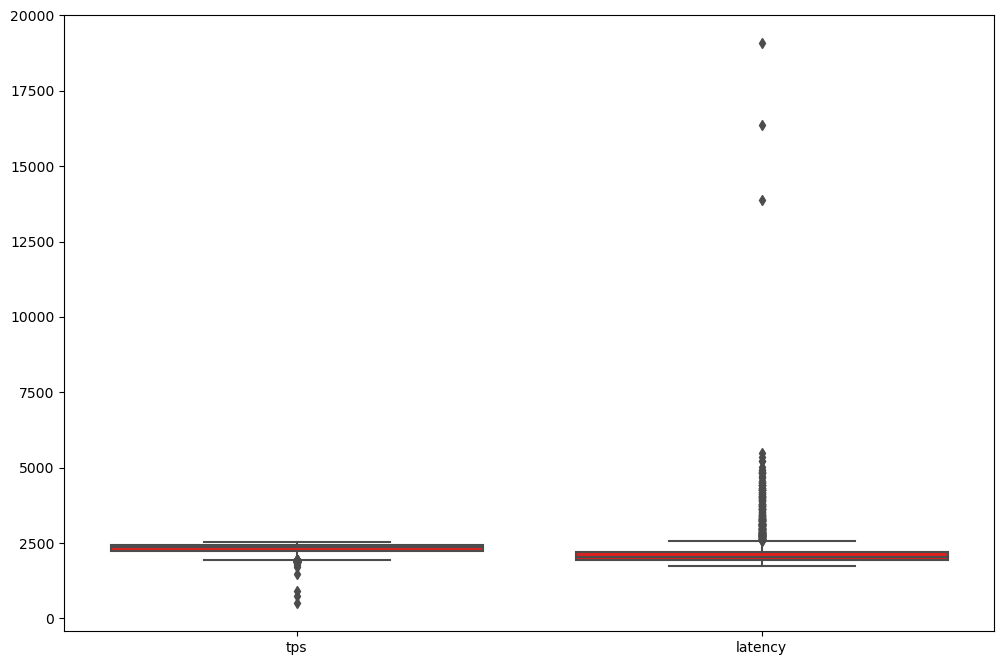

In [617]:
###Remove the outlier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12,8))
sns.boxplot(data=external, color = 'red')
plt.show



In [618]:
###Remove the outlier by IQR
import numpy as np
def outliers_iqr(data):
    q1, q3 = np.percentile(data, [25,75])
    iqr = q3 - q1
    lower_bound = q1 - (iqr * 1.5)
    upper_bound = q3 + (iqr * 1.5)
    
    return np.where((data > upper_bound) | (data < lower_bound))

In [619]:

external_outlier_index = outliers_iqr(external)[0]

# external_outlier_index = pd.DataFrame(external_outlier_index)
external_outlier = external.loc[external_outlier_index]
#print(external_outlier)

final_external_index = [] #이상치가 다 제거된 상태

# print(after_external_outlier)
for i in external.index:
    if i not in external_outlier_index:
        final_external_index.append(i)
        
final_external_clean = external.loc[final_external_index]
final_external_clean = final_external_clean.reset_index(drop=True)

final_exter_list = final_external_clean.values.tolist()
# print(final_external_clean)
# print(final_exter_list[0])
# print(type(final_exter_list))
# print(final_exter_list.index)
#print(type(final_external_clean))


# final_external_clean = pd.DataFrame(final_external_clean)

        
# final_external = pd.DataFrame(final_external)
print(final_external_clean)
#최종 이상치 제거       
print(len(final_external_clean))
print(type(final_external_clean))


              tps  latency
0     2103.142511     2071
1     2332.073324     1982
2     2401.571570     1826
3     2417.250149     1994
4     1975.451662     2692
...           ...      ...
1845  2408.629619     1842
1846  2479.992644     1991
1847  2077.754788     2615
1848  2475.077015     1982
1849  2473.372370     1841

[1850 rows x 2 columns]
1850
<class 'pandas.core.frame.DataFrame'>


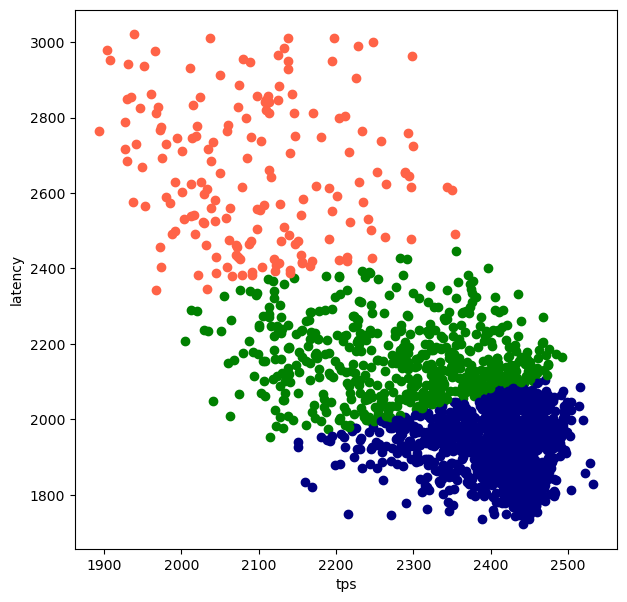

In [620]:
np_final_external = final_external_clean.to_numpy()
kmeans = KMeans(n_clusters=3)
kmeans.fit(np_final_external)
labels = kmeans.labels_

fig = plt.figure(figsize=(7,7))
fig.set_facecolor('white')
for i, label in enumerate(labels):
    if label == 0:
        color = 'navy'
    elif label == 1:
        color = 'tomato'
    elif label == 2:
        color = 'green'
    elif label == 3:
        color = 'orange'
    plt.scatter(np_final_external[i,0],np_final_external[i,1], color=color)

plt.xlabel('tps')
plt.ylabel('latency')
plt.show()

In [ ]:
###Remove the outlier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(12,8))
sns.boxplot(data=final_external_clean, color = 'red')
plt.show

In [ ]:
raw_knobs_outlier = []

for k in raw_knobs.index:
    if k not in external_outlier_index:
        raw_knobs_outlier.append(k)

final_knobs_clean = raw_knobs.loc[raw_knobs_outlier]
final_knobs_clean = final_knobs_clean.reset_index(drop=True)


#최종 이상치 제거        
# print(type(final_knobs_clean))
print(final_knobs_clean)

In [ ]:
# ### isolation forest parmeter tuning ###

# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.ensemble import IsolationForest

# clf_outlier = IsolationForest()

# clf_outlier_grid = {
#     # "n_estimators" : [100, 200, 300, 400, 500],
#     # "learning_rate" : [0.001, 0.005, 0.0001, 0.0005],
#     # "max_depth" : [4, 6, 8, 10, 12]
#     "n_estimators" : [1000, 1500, 2000, 500],
#     "contamination" : [0.001,0.003, 0.005, 0.0001, 0.0005],
# }

# # cv=KFold(n_splits=6, random_state = 1)

# outlier_grid = GridSearchCV(estimator = clf_outlier, param_grid = clf_outlier_grid, scoring = "accuracy"
#                         , cv=3) #n_jobs = -1, verbose = 1)

# # clf_grid.fit(scaled_X_train, y_train)
# outlier_grid.fit(scaled_X_train, y_train)
# # print('XGB 예측 정확도: {:.4f}'.format(xgb_grid.best_score_))
# print(outlier_grid.best_params_)


In [ ]:
# # parameter setting
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# from sklearn.ensemble import IsolationForest

# n_estimators = list(range(1000, 2000, 100))
# contamination = [0.001, 0.002, 0.003, 0.005, 0.01, 0.0001, 0.0005]


# result = pd.DataFrame(columns=['n_estimators', 'contamination', 'f1'])
# # fitting and check
# for n_est in n_estimators:
#   for cont in contamination:
#     model = IsolationForest(n_estimators=n_est, max_samples=len(external), contamination=cont, random_state=42, verbose=0)
#     y_valid = model.fit(external)

#     y_pred_valid = model.predict(external)# model prediction and label conversion
#     f1 = f1_score(y_valid, y_pred_valid, average='macro')
#     result.loc[len(result)] = [n_est, cont, f1]

#     print(f'n_estimator : {n_est}, contamination : {cont} ====> f1 : {f1}')

In [834]:
###remove outlier by isolation forest (external)
import collections
from sklearn.ensemble import IsolationForest

clf_outlier = IsolationForest(n_estimators=200,
                      max_samples="auto", 
                      contamination=0.003,
                      max_features=1,
                      bootstrap=False,
                      n_jobs=-1,
                      random_state=42,
                      verbose=0)

clf_outlier.fit(external)

y_pred_outliers = clf_outlier.predict(external)

collections.Counter(y_pred_outliers)

external['out'] = y_pred_outliers
outliers = external.loc[external['out'] == -1]
outlier_index = list(outliers.index)

# print(list(outliers.index))

final_external_index = [] #이상치가 다 제거된 상태

# print(after_external_outlier)
for i in external.index:
    if i not in outlier_index:
        final_external_index.append(i)
        
final_external_clean = external.loc[final_external_index]
final_external_clean = final_external_clean.reset_index(drop=True)
final_external_clean_fin = final_external_clean.drop(['out'], axis=1)
#final_exter_list = final_external_clean.values.tolist()

#final preprocessing data with scaler and remove outlier
print(final_external_clean)






/home/sein/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              tps  latency  out
0     2103.142511     2071    1
1     2332.073324     1982    1
2     2401.571570     1826    1
3     2417.250149     1994    1
4     1975.451662     2692    1
...           ...      ...  ...
1989  2408.629619     1842    1
1990  2479.992644     1991    1
1991  2077.754788     2615    1
1992  2475.077015     1982    1
1993  2473.372370     1841    1

[1994 rows x 3 columns]


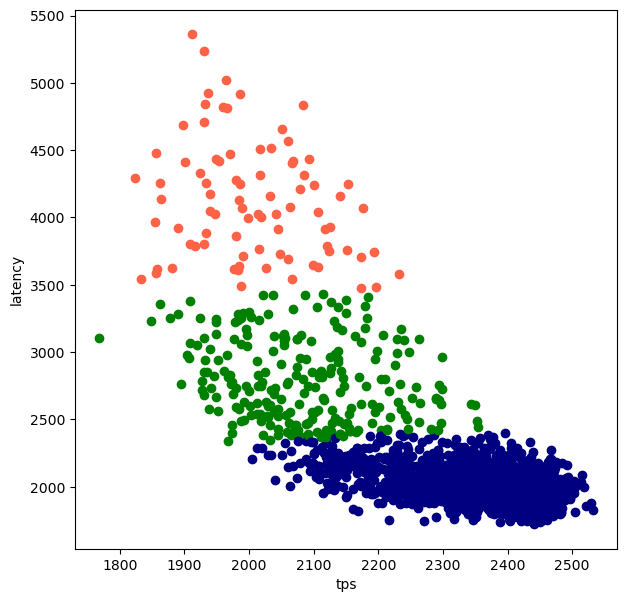

In [837]:
np_final_external = final_external_clean_fin.to_numpy()
kmeans = KMeans(n_clusters=3)
kmeans.fit(np_final_external)
labels = kmeans.labels_

fig = plt.figure(figsize=(7,7))
fig.set_facecolor('white')
for i, label in enumerate(labels):
    if label == 0:
        color = 'navy'
    elif label == 1:
        color = 'tomato'
    elif label == 2:
        color = 'green'
    elif label == 3:
        color = 'orange'
    plt.scatter(np_final_external[i,0],np_final_external[i,1], color=color)

plt.xlabel('tps')
plt.ylabel('latency')
plt.show()

In [835]:
raw_knobs_outlier = []

for k in raw_knobs.index:
    if k not in outlier_index:
        raw_knobs_outlier.append(k)

final_knobs_clean = raw_knobs.loc[raw_knobs_outlier]
final_knobs_clean = final_knobs_clean.reset_index(drop=True)


#최종 이상치 제거        
print(final_knobs_clean)

     table_open_cache innodb_buffer_pool_size innodb_buffer_pool_instances  \
0                3593              2159671148                           26   
1                3062              5331384734                           29   
2                7029              1098926986                           46   
3                2804              6334359807                           10   
4                7492              4474388924                            5   
...               ...                     ...                          ...   
1989             9016              6026263806                           61   
1990             4373               791730602                           63   
1991             7818              7125967202                            8   
1992             7039              1666601102                            8   
1993             7668              3494389974                           52   

     innodb_purge_threads innodb_read_io_threads innodb_write_i

In [836]:
###TPS랑 Latency 따로 scaling하기###
# Y값을 one-hot으로 바꾸기
# +) 이상치 제거한 후 넣기

# X_train.index
#전체 linear model에 대한 input, ouput // input = configuration , output = tps, latency
#input값은 attention을 통해 나온 attn_output , output은 tps와 latency
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
import torch
import torch.nn as nn
random_seed = 777
import random
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#workload6에 대한 external metric
#EXTERNAL = pd.read_csv("../data/configs_new_dataset/external_new_dataset/external_results_6.csv", index_col=0)

raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)

#scaling 후 outlier 제거
# scaled_knob = MinMaxScaler().fit(raw_knobs)
# knob_preprocessing = scaled_knob.transform(raw_knobs)
# knob_preprocessing = pd.DataFrame(knob_preprocessing)

#outlier 제거 후 scaling
scaled_knob = MinMaxScaler().fit(final_knobs_clean)
knob_preprocessing = scaled_knob.transform(final_knobs_clean)
knob_preprocessing = pd.DataFrame(knob_preprocessing)

#scaling 후 outlier 제거
# scaled_external = StandardScaler().fit(external)
# external_preprocessing = scaled_external.transform(external)
# external_preprocessing = pd.DataFrame(external_preprocessing)



#outlier 제거 후 scaling
scaled_external = StandardScaler().fit(final_external_clean_fin)
external_preprocessing = scaled_external.transform(final_external_clean_fin)
external_preprocessing = pd.DataFrame(external_preprocessing)

#원래 external은 standard
#여기서부터 쭉 주석
# tps = final_external_clean['tps']
# latency = final_external_clean['latency']


# tps = np.array(tps)
# tps.reshape(-1, 1)
# tps = pd.DataFrame(tps)
# scaled_tps = StandardScaler().fit(tps)
# tps_preprocessing = scaled_tps.transform(tps)
# tps_preprocessing = pd.DataFrame(tps_preprocessing)
# # print(tps_preprocessing)

# latency = np.array(latency)
# latency.reshape(-1, 1)
# latency = pd.DataFrame(latency)
# scaled_latency = StandardScaler().fit(latency)
# latency_preprocessing = scaled_latency.transform(latency)
# latency_preprocessing = pd.DataFrame(latency_preprocessing)
# # print(latency_preprocessing)
# external_preprocessing = pd.concat([tps_preprocessing,latency_preprocessing], axis = 1)

# final_knobs_clean = np.array(final_knobs_clean).astype(np.float)
# final_external_clean = np.array(final_external_clean).astype(np.float)
#scaling 후 outlier 제거 후 split
X_train, X_test, y_train, y_test = train_test_split(knob_preprocessing, external_preprocessing, test_size=0.4, shuffle=True)

#outlier 제거 후 scaling 후 split
#X_train, X_test, y_train, y_test = train_test_split(knob_preprocessing, external_preprocessing, test_size=0.4, shuffle=True)

# print(type(final_knobs_clean)) #numpy
# print(type(scaled_X_train)) #numpy

scaled_X_train = X_train
scaled_X_test = X_test
scaled_Y_train = y_train
scaled_Y_test = y_test

import torch

# scaled_X_train = torch.Tensor(scaled_X_train).cuda()
# scaled_Y_train = torch.Tensor(scaled_Y_train).cuda()
# scaled_X_test = torch.Tensor(scaled_X_test).cuda()
# scaled_Y_test = torch.Tensor(scaled_Y_test).cuda()

scaled_X_train, scaled_Y_train = torch.tensor(scaled_X_train.values), torch.tensor(scaled_Y_train.values).cuda()
scaled_X_test, scaled_Y_test = torch.tensor(scaled_X_test.values), torch.tensor(scaled_Y_test.values).cuda()

# scaled_X_train, scaled_Y_train = torch.tensor(scaled_X_train), torch.tensor(scaled_Y_train).cuda()
# scaled_X_test, scaled_Y_test = torch.tensor(scaled_X_test), torch.tensor(scaled_Y_test).cuda()



from torch.utils.data import TensorDataset, DataLoader
dataset_tr = TensorDataset(scaled_X_train, scaled_Y_train)
dataset_te = TensorDataset(scaled_X_test, scaled_Y_test)

## prepare experiment
batch_size = 32
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=batch_size, shuffle=False)

import torch.optim as optim
from sklearn.metrics import r2_score
criterion = nn.MSELoss().cuda() #regression
network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
    #train
optimizer = optim.Adam(network.parameters(), lr=0.001)

for epoch in range(200):
    total_loss = 0.
    ## start iteration
    network.train()

    for data, target in dataloader_tr:
        optimizer.zero_grad()
        
        data = np.array(data)
        onehot = clf.predict(data) #one-hot classification model의 결과
        
        stack_onehot = []
        
        for i in onehot:
           onehot_li = [0,0,0]
           onehot_li[i] += 1 
           stack_onehot.append(onehot_li)
        stack_onehot = torch.tensor(stack_onehot)

        cluster = stack_onehot.float().cuda()

        
        data = torch.tensor(data).float().cuda()
        
        #x,y 를 받음 / conf-linear-attention & onehot-linear-attention
        metrics, score = network(data, cluster)
        # metrics = metrics.float()
        target = target.float().cuda()
        loss = criterion(metrics, target)

        #backpropagation
        loss.backward()
        # update the model's weight(parameter value)
        optimizer.step()
        total_loss += loss.item() 
    ## calculte mean of loss 
    total_loss /= len(dataloader_tr)

    
    ## check a log (real-time experiment performance)
    if epoch % 10 == 0:
        total_val_loss = 0
     
        
        ## validation performance check
        network.eval()
        with torch.no_grad():
            preds = torch.Tensor().cuda()
            trues = torch.Tensor().cuda()
    
            for data, target in dataloader_te:
                data = np.array(data)
                onehot = clf.predict(data)
                stack_onehot = []
                
                for i in onehot:
                    onehot_li = [0,0,0]
                    onehot_li[i] += 1 
                    stack_onehot.append(onehot_li)
                stack_onehot = torch.tensor(stack_onehot)
                cluster = stack_onehot.float().cuda()                

                data = torch.tensor(data).float().cuda()
                metrics, score = network(data, cluster)
                #metrics = linear-attention-linear
                metrics = metrics.float()
                target = target.float().cuda()   
                loss = criterion(metrics, target)  
                ## backpropagation
                total_val_loss += loss.item()
                
                #r2_score를 위한
                true = torch.Tensor(target).cuda()
                preds = torch.cat((preds, metrics))
                trues = torch.cat((trues, true))
                
                
                    
            r2_res = r2_score(trues.cpu().numpy().squeeze(), preds.cpu().numpy().squeeze(), multioutput='raw_values')
            total_val_loss /= len(dataloader_te) 
            print(f'[{epoch+1}epoch] tr_loss:{total_loss:.4f} | val_loss:{total_val_loss:.4f} | r2 : {r2_res}') 
            


[1epoch] tr_loss:1.0395 | val_loss:0.9886 | r2 : [-0.00114833 -0.00133294]
[11epoch] tr_loss:0.4532 | val_loss:0.5166 | r2 : [0.31020623 0.65310193]
[21epoch] tr_loss:0.4397 | val_loss:0.5061 | r2 : [0.32144156 0.66311846]
[31epoch] tr_loss:0.4350 | val_loss:0.5085 | r2 : [0.31900604 0.66069069]
[41epoch] tr_loss:0.4300 | val_loss:0.5086 | r2 : [0.31912304 0.66047446]
[51epoch] tr_loss:0.4383 | val_loss:0.5337 | r2 : [0.29729403 0.63115912]
[61epoch] tr_loss:0.4403 | val_loss:0.5151 | r2 : [0.31610011 0.65002922]
[71epoch] tr_loss:0.4328 | val_loss:0.5104 | r2 : [0.31802307 0.65792999]
[81epoch] tr_loss:0.4327 | val_loss:0.5156 | r2 : [0.31443214 0.65087636]
[91epoch] tr_loss:0.4439 | val_loss:0.5191 | r2 : [0.31175033 0.64630091]
[101epoch] tr_loss:0.4291 | val_loss:0.5074 | r2 : [0.32166525 0.6603271 ]
[111epoch] tr_loss:0.4341 | val_loss:0.5143 | r2 : [0.31510519 0.65286103]
[121epoch] tr_loss:0.4449 | val_loss:0.5090 | r2 : [0.32063116 0.65798812]
[131epoch] tr_loss:0.4367 | val_lo

In [291]:
#####parameter with GridSearch랑 linear 합치기###

# 문제점 : X는 같은데 clf와 linear 모델의 y가 다름

import xgboost as xgb
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
torch.nn.functional.one_hot
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#raw data가져오기
wk = 6
print(f'=WK{wk}===============================================================')
raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)
np_external = external.to_numpy()
kmeans = KMeans(n_clusters=3)
kmeans.fit(np_external)
labels = kmeans.labels_
get_class_num(labels)

################################################
X = raw_knobs
Y_clf = labels
Y_lin = external

scaled_X = MinMaxScaler().fit(raw_knobs)
scaled_Y_lin = StandardScaler().fit(external)
################################################


X_clf_train, X_clf_test, y_clf_train, y_clf_test = train_test_split(raw_knobs, labels, test_size=0.4, shuffle=True)
X_clf_scaler = MinMaxScaler().fit(X_clf_train)

scaled_X_clf_train = torch.Tensor(X_clf_scaler.transform(X_clf_train)).cuda()
scaled_X_clf_test = torch.Tensor(X_clf_scaler.transform(X_clf_test)).cuda()

# clf = xgb.XGBClassifier(n_estimators=50, learning_rate = 0.001, max_depth=14, random_state=0)
#clf = xgb.XGBClassifier(n_estimators=50, learning_rate = 0.001 ,max_depth=14)
clf = xgb.XGBClassifier(n_estimators=1500, learning_rate = 0.005, 
                        max_depth = 6, max_leaves = 255, n_jobs=-1)
clf.fit(scaled_X_clf_train, y_clf_train)
clf_pred = clf.predict(scaled_X_clf_test)
print('********true********')
get_class_num(y_clf_test)
print('********pred********')
get_class_num(clf_pred)                                                                        

# 전체 linear model에 대한 input, ouput // input = configuration , output = tps, latency
# input값은 attention을 통해 나온 attn_output , output은 tps와 latency
# one-hot vector로 바꾸는 과정은 임베딩 전에

random_seed = 777
import random
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)


#X = configuraion, Y = scaling external metrics
X_train, X_test, y_train, y_test = train_test_split(raw_knobs, external, test_size=0.4, shuffle=True)


# train_index = X_train.index
# test_index = X_test.index

#X,Y값 scaling
X_scaler = MinMaxScaler().fit(X_train)
Y_scaler = StandardScaler().fit(y_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
scaled_Y_train = Y_scaler.transform(y_train)
scaled_Y_test = Y_scaler.transform(y_test)
# train_TPS = y_train[:,0]
# train_Latency = y_train[:,1]
# test_TPS = y_test[:,0]
# test_Latency = y_test[:,1]
import torch
scaled_X_train, scaled_Y_train = torch.tensor(scaled_X_train), torch.tensor(scaled_Y_train).cuda()
scaled_X_test, scaled_Y_test = torch.tensor(scaled_X_test), torch.tensor(scaled_Y_test).cuda()

from torch.utils.data import TensorDataset, DataLoader
dataset_tr = TensorDataset(scaled_X_train, scaled_Y_train)
dataset_te = TensorDataset(scaled_X_test, scaled_Y_test)

## prepare experiment
batch_size = 32
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=batch_size, shuffle=False)

import torch.optim as optim
from sklearn.metrics import r2_score
#Attention
# network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
# network = ReshapeNet(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2, group_dim=8).cuda()

# import torch.nn.functional as F
# optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.1)
criterion = nn.MSELoss().cuda() #regression
# loss = F.mse_loss(output, target)
####추후 수정
# import warnings
# warnings.filterwarnings('ignore')
network = ReshapeNet(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2, group_dim=8).cuda()
    #train
optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.1)
for epoch in range(200):
    #loss_tr = self.train(self.model, dataloader_tr)
    total_loss = 0.

    ## start iteration
    network.train()
    # for parameter in network.parameters():
    #     print(parameter.requires_grad) 
    for data, target in dataloader_tr:
        optimizer.zero_grad()
        
        data = np.array(data)
        onehot = clf.predict(data) #one-hot classification model의 결과
        onehot = torch.Tensor(onehot)
        onehot = onehot[:,None].float().cuda() #차원 늘리기 like unsqueeze
        
        data = torch.tensor(data).float().cuda()
        
        #x,y 를 받음 / conf-linear-attention & onehot-linear-attention
        metrics = network(data, onehot)
        # metrics = metrics.float()
        target = target.float().cuda()
        loss = criterion(metrics, target)
        # loss = F.mse_loss(metrics, target)
        
        
        
        # Latency, TPS = network(data, pred)       
        # label_TPS = target[:,0].float().cuda()
        # label_Latency = target[:,1].float().cuda()  
        # loss_Latency = criterion(Latency, label_Latency)
        # loss_TPS = criterion(TPS, label_TPS)   
        # a = list(network.parameters())[0]
        # print(list(network.parameters())[0].grad)
        #loss = loss_Latency + loss_TPS
        #backpropagation
        loss.backward()
        # update the model's weight(parameter value)
        optimizer.step()
        # b = list(network.parameters())[0]
        # print(torch.equal(a.data, b.data))
        ## stack(summation) loss value for each epoch
        total_loss += loss.item()
        
    ## calculte mean of loss 
    total_loss /= len(dataloader_tr)
    # print(f'[{epoch+1}epoch] tr_loss:{total_loss}')
    
    ## check a log (real-time experiment performance)
    if epoch % 10 == 0:
        total_val_loss = 0
        # total_R2_Latency = 0
        # total_R2_TPS = 0
        # print("--------results-------")
        # print("MSE_Loss  = ",total_loss)
     
        
        ## validation performance check
        network.eval()
        with torch.no_grad():
            # trues = []
            # preds = []
            preds = torch.Tensor().cuda()
            trues = torch.Tensor().cuda()
    
            for data, target in dataloader_te:
                data = np.array(data)
                onehot = clf.predict(data)
                onehot = torch.Tensor(onehot)
                onehot = onehot[:,None].float().cuda()
        
                data = torch.tensor(data).float().cuda()
                metrics = network(data, onehot)
                #metrics = linear-attention-linear
                metrics = metrics.float()
                
                # Latency, TPS = network(data, pred)       
                
                # label_TPS = target[:,0].float().cuda()
                # label_Latency = target[:,1].float().cuda()  
                
                # loss_Latency = criterion(Latency, label_Latency)
                # loss_TPS = criterion(TPS, label_TPS) 
                target = target.float().cuda()
                
                loss = criterion(metrics, target)  
                ## backpropagation
                #loss = loss_Latency + loss_TPS
                # R2_TPS = r2_score(label_TPS.detach().cpu().numpy(), TPS.detach().cpu().numpy())
                
                # R2_Latency = r2_score(label_Latency.detach().cpu().numpy(), Latency.detach().cpu().numpy())
                total_val_loss += loss.item()
                # total_R2_Latency += R2_Latency
                # total_R2_TPS += R2_TPS
            

                # pred = metrics.detach().cpu().numpy().squeeze()   
                # true = target.detach().cpu().numpy().squeeze()
                # preds.append(pred)
                # trues.append(true)
                # r2_res = r2_score(true, pred)
                
                #r2_score를 위한
                true = torch.Tensor(target).cuda()
                preds = torch.cat((preds, metrics))
                trues = torch.cat((trues, true))
                    
            r2_res = r2_score(trues.cpu().numpy().squeeze(), preds.cpu().numpy().squeeze(), multioutput='raw_values') 
            #R2_score = r2_score(scaled_Y_test.detach().cpu().numpy() , metrics.detach().cpu().numpy())
            total_val_loss /= len(dataloader_te) 
            # total_R2_Latency /= len(dataloader_te) 
            # total_R2_TPS /= len(dataloader_te) 
            
            # logger.info("Validation_loss : ", total_loss)  
            # print("Validation__MSEloss : ", total_loss)  
            # print("Validation__R2 : ", r2_res)
            # print("Validation__R2 : ", r2_res)
            print(f'[{epoch+1}epoch] tr_loss:{total_loss} | val_loss:{total_val_loss} | r2 :{r2_res}')
            # print("Validation__R2_Latency : ", total_R2_Latency)
            # print("Validation__R2_TPS : ", total_R2_TPS)
            
            



=WK0===============================================================
# of the largest class / # of data = 0.844
0 : 1688
1 : 296
2 : 16


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
# 전체 linear model에 대한 input, ouput // input = configuration , output = tps, latency
# input값은 attention을 통해 나온 attn_output , output은 tps와 latency
# one-hot vector로 바꾸는 과정은 임베딩 전에

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

random_seed = 777
import random
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#workload6에 대한 external metric
EXTERNAL = pd.read_csv("../data/configs_new_dataset/external_new_dataset/external_results_6.csv", index_col=0)

raw_knobs, external = get_data(KNOB_PATH, EXTERNAL_PATH, wk)
#external metric에 대한 scaling
# scaler_EXT = StandardScaler().fit(EXTERNAL)
# EXT_Preprocessing = scaler_EXT.transform(EXTERNAL)

#X = configuraion, Y = scaling external metrics
X_train, X_test, y_train, y_test = train_test_split(raw_knobs, EXTERNAL, test_size=0.4, shuffle=True)


# train_index = X_train.index
# test_index = X_test.index

#X,Y값 scaling
X_scaler = MinMaxScaler().fit(X_train)
Y_scaler = StandardScaler().fit(y_train)

scaled_X_train = X_scaler.transform(X_train)
scaled_X_test = X_scaler.transform(X_test)
scaled_Y_train = Y_scaler.transform(y_train)
scaled_Y_test = Y_scaler.transform(y_test)
# train_TPS = y_train[:,0]
# train_Latency = y_train[:,1]
# test_TPS = y_test[:,0]
# test_Latency = y_test[:,1]
import torch
scaled_X_train, scaled_Y_train = torch.tensor(scaled_X_train), torch.tensor(scaled_Y_train).cuda()
scaled_X_test, scaled_Y_test = torch.tensor(scaled_X_test), torch.tensor(scaled_Y_test).cuda()

from torch.utils.data import TensorDataset, DataLoader
dataset_tr = TensorDataset(scaled_X_train, scaled_Y_train)
dataset_te = TensorDataset(scaled_X_test, scaled_Y_test)

## prepare experiment
batch_size = 32
dataloader_tr = DataLoader(dataset_tr, batch_size=batch_size, shuffle=True)
dataloader_te = DataLoader(dataset_te, batch_size=batch_size, shuffle=False)

import torch.optim as optim
from sklearn.metrics import r2_score
#Attention
# network = model(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2).cuda()
# network = ReshapeNet(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2, group_dim=8).cuda()

# import torch.nn.functional as F
# optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.1)
criterion = nn.MSELoss().cuda() #regression
# loss = F.mse_loss(output, target)
####추후 수정
# import warnings
# warnings.filterwarnings('ignore')
network = ReshapeNet(input_dim = len(scaled_X_train[0]), hidden_dim = 32, output_dim = 2, group_dim=8).cuda()
    #train
optimizer = optim.Adam(network.parameters(), lr=0.001, weight_decay=0.1)
for epoch in range(200):
    #loss_tr = self.train(self.model, dataloader_tr)
    total_loss = 0.

    ## start iteration
    network.train()
    # for parameter in network.parameters():
    #     print(parameter.requires_grad) 
    for data, target in dataloader_tr:
        optimizer.zero_grad()
        
        data = np.array(data)
        onehot = clf.predict(data) #one-hot classification model의 결과
        onehot = torch.Tensor(onehot)
        onehot = onehot[:,None].float().cuda() #차원 늘리기 like unsqueeze
        
        data = torch.tensor(data).float().cuda()
        
        #x,y 를 받음 / conf-linear-attention & onehot-linear-attention
        metrics = network(data, onehot)
        # metrics = metrics.float()
        target = target.float().cuda()
        loss = criterion(metrics, target)
        # loss = F.mse_loss(metrics, target)
        
        
        
        # Latency, TPS = network(data, pred)       
        # label_TPS = target[:,0].float().cuda()
        # label_Latency = target[:,1].float().cuda()  
        # loss_Latency = criterion(Latency, label_Latency)
        # loss_TPS = criterion(TPS, label_TPS)   
        # a = list(network.parameters())[0]
        # print(list(network.parameters())[0].grad)
        #loss = loss_Latency + loss_TPS
        #backpropagation
        loss.backward()
        # update the model's weight(parameter value)
        optimizer.step()
        # b = list(network.parameters())[0]
        # print(torch.equal(a.data, b.data))
        ## stack(summation) loss value for each epoch
        total_loss += loss.item()
        
    ## calculte mean of loss 
    total_loss /= len(dataloader_tr)
    # print(f'[{epoch+1}epoch] tr_loss:{total_loss}')
    
    ## check a log (real-time experiment performance)
    if epoch % 10 == 0:
        total_val_loss = 0
        # total_R2_Latency = 0
        # total_R2_TPS = 0
        # print("--------results-------")
        # print("MSE_Loss  = ",total_loss)
     
        
        ## validation performance check
        network.eval()
        with torch.no_grad():
            # trues = []
            # preds = []
            preds = torch.Tensor().cuda()
            trues = torch.Tensor().cuda()
    
            for data, target in dataloader_te:
                data = np.array(data)
                onehot = clf.predict(data)
                onehot = torch.Tensor(onehot)
                onehot = onehot[:,None].float().cuda()
        
                data = torch.tensor(data).float().cuda()
                metrics = network(data, onehot)
                #metrics = linear-attention-linear
                metrics = metrics.float()
                
                # Latency, TPS = network(data, pred)       
                
                # label_TPS = target[:,0].float().cuda()
                # label_Latency = target[:,1].float().cuda()  
                
                # loss_Latency = criterion(Latency, label_Latency)
                # loss_TPS = criterion(TPS, label_TPS) 
                target = target.float().cuda()
                
                loss = criterion(metrics, target)  
                ## backpropagation
                #loss = loss_Latency + loss_TPS
                # R2_TPS = r2_score(label_TPS.detach().cpu().numpy(), TPS.detach().cpu().numpy())
                
                # R2_Latency = r2_score(label_Latency.detach().cpu().numpy(), Latency.detach().cpu().numpy())
                total_val_loss += loss.item()
                # total_R2_Latency += R2_Latency
                # total_R2_TPS += R2_TPS
            

                # pred = metrics.detach().cpu().numpy().squeeze()   
                # true = target.detach().cpu().numpy().squeeze()
                # preds.append(pred)
                # trues.append(true)
                # r2_res = r2_score(true, pred)
                
                #r2_score를 위한
                true = torch.Tensor(target).cuda()
                preds = torch.cat((preds, metrics))
                trues = torch.cat((trues, true))
                    
            r2_res = r2_score(trues.cpu().numpy().squeeze(), preds.cpu().numpy().squeeze(), multioutput='raw_values') 
            #R2_score = r2_score(scaled_Y_test.detach().cpu().numpy() , metrics.detach().cpu().numpy())
            total_val_loss /= len(dataloader_te) 
            # total_R2_Latency /= len(dataloader_te) 
            # total_R2_TPS /= len(dataloader_te) 
            
            # logger.info("Validation_loss : ", total_loss)  
            # print("Validation__MSEloss : ", total_loss)  
            # print("Validation__R2 : ", r2_res)
            # print("Validation__R2 : ", r2_res)
            print(f'[{epoch+1}epoch] tr_loss:{total_loss} | val_loss:{total_val_loss} | r2 :{r2_res}')
            # print("Validation__R2_Latency : ", total_R2_Latency)
            # print("Validation__R2_TPS : ", total_R2_TPS)
            
            
